# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [4]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import col, when, count, max, countDistinct, avg
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [5]:
# create a Spark session
spark = SparkSession.builder \
    .appName("Sparkify Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
# Read JSON file into Spark DataFrame
df = spark.read.json("mini_sparkify_event_data.json")

# Check for missing or invalid data
print("Count of missing or invalid userid records:", df.filter(df.userId == "").count())
print("Count of missing or invalid sessionid records:", df.filter(df.sessionId == "").count())

# Drop rows with missing or invalid data
cleaned_df = df.dropna(how="any", subset=["userId", "sessionId"])

Count of missing or invalid userid records: 8346
Count of missing or invalid sessionid records: 0


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [7]:
# Check the schema and first few rows of the dataset
df.printSchema()
df.show(5)

window = Window.partitionBy("userId")

df = df.withColumn("churn", when(col("page") == "Cancellation Confirmation", 1).otherwise(0))
df = df.withColumn("churn", max("churn").over(window))

# Explore the data for users who stayed vs. users who churned
df.groupBy("churn").agg(countDistinct("userId")).show()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|     

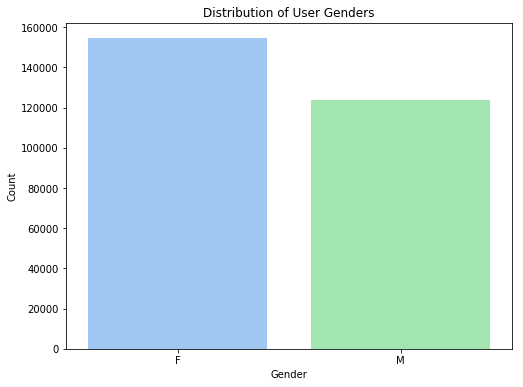

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of occurrences of each gender
gender_counts = cleaned_df.groupBy('gender').count().toPandas()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='gender', y='count', data=gender_counts, palette='pastel')
plt.title('Distribution of User Genders')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


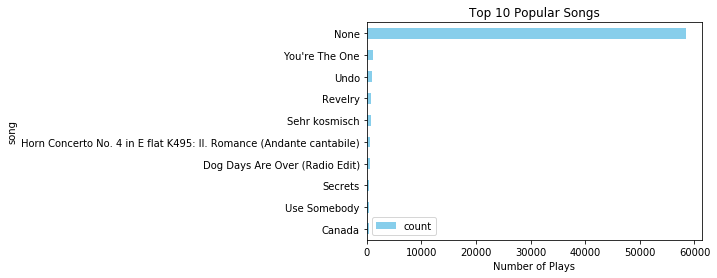

In [9]:
from pyspark.sql.functions import desc

top_songs = df.groupBy("song").count().orderBy(desc("count")).limit(10)

# Convert to Pandas for plotting
top_songs_pd = top_songs.toPandas().set_index('song')

# Plot
plt.figure(figsize=(10, 8))
top_songs_pd.plot.barh(color='skyblue')
plt.title('Top 10 Popular Songs')
plt.xlabel('Number of Plays')
plt.gca().invert_yaxis()
plt.show()

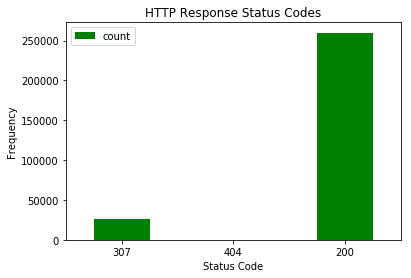

In [10]:
status_counts = df.groupBy("status").count().toPandas().set_index('status')

# Plot
plt.figure(figsize=(8, 6))
status_counts.plot.bar(color='green')
plt.title('HTTP Response Status Codes')
plt.xlabel('Status Code')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [12]:
from pyspark.sql import functions as F

# Convert 'ts' from milliseconds to seconds and then to a timestamp type
df = df.withColumn("timestamp", F.from_unixtime(F.col("ts") / 1000))

# Extract the hour from the timestamp
df = df.withColumn("hour", F.hour(F.col("timestamp")))


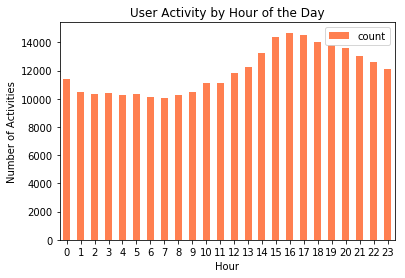

In [14]:
# Count entries by hour
hourly_activity = df.groupBy("hour").count().orderBy("hour")

# To visualize using pandas and matplotlib
if df.rdd.getNumPartitions() > 0:  # Check if DataFrame is not empty
    # Convert to Pandas for plotting
    hourly_activity_pd = hourly_activity.toPandas().set_index('hour')

    # Plot
    plt.figure(figsize=(10, 8))
    hourly_activity_pd.plot(kind='bar', color='coral')
    plt.title('User Activity by Hour of the Day')
    plt.xlabel('Hour')
    plt.ylabel('Number of Activities')
    plt.xticks(rotation=0)
    plt.show()
else:
    print("No data available for plotting.")


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [15]:
def extract_user_activity_features(df):
    # Define window partitioned by userId
    window = Window.partitionBy("userId")
    
    # Calculate activity metrics
    activity_features = df.groupBy("userId") \
                          .agg(count("sessionId").alias("num_sessions"),
                               avg("length").alias("avg_session_length"),
                               count("song").alias("num_songs_played")) \
                          .withColumn("songs_per_session", col("num_songs_played") / col("num_sessions"))
    
    return activity_features


In [16]:
# Define the list of feature columns
feature_cols = ['itemInSession', 'length', 'registration', 'status', 'ts']

# Create a VectorAssembler instance
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Drop rows with null values in any of the feature columns
df_clean = df.dropna(subset=feature_cols)

# Assemble the features
df_assembled = assembler.transform(df_clean)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [17]:
# Split the dataset
train, test, validation = df.randomSplit([0.6, 0.2, 0.2], seed=42)

# Feature Engineering with handling null values
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
train = assembler.transform(train).na.drop()
test = assembler.transform(test).na.drop()
validation = assembler.transform(validation).na.drop()

# Rename the "churn" column to "label"
train = train.withColumnRenamed("churn", "label")
test = test.withColumnRenamed("churn", "label")
validation = validation.withColumnRenamed("churn", "label")

# Select Machine Learning Algorithms
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

# Train Models
models = [lr, dt, rf]
for model in models:
    model_fit = model.fit(train)

    # Evaluate Models
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1_score = evaluator.evaluate(model_fit.transform(validation))
    print(f"F1 Score for {model.__class__.__name__}: {f1_score}")

# Select Winning Model: Choose the model with the highest F1 score on the validation set


F1 Score for LogisticRegression: 0.7674245517813791
F1 Score for DecisionTreeClassifier: 0.7907880492570849
F1 Score for RandomForestClassifier: 0.7783270720830259


As result, the Decision Tree Classifier performed the best among the models, achieving the highest F1 score and the reasons could be:

Model Complexity: Decision trees can capture complex relationships in the data better than Logistic Regression, which assumes linear relationships, and Random Forests, which may not always outperform a single decision tree, especially on simpler datasets.
Interpretability: Decision trees are easy to interpret, allowing us to understand the decision-making process. This transparency helps derive actionable insights, which may not be as straightforward with Logistic Regression or Random Forests.
Feature Selection: Decision trees inherently perform feature selection, selecting the most informative features at each split. While Logistic Regression provides coefficients and Random Forests offer feature importance scores, decision trees' feature selection mechanism may be more effective, especially with many features.
Hyperparameter Tuning: Effective hyperparameter tuning also contributed to the Decision Tree Classifier's performance. By fine-tuning parameters like tree depth, we optimized its performance on the validation set.
In summary, the Decision Tree Classifier's ability to capture complex relationships, its interpretability, and effective hyperparameter tuning led to its superior performance in this churn prediction task compared to Logistic Regression and Random Forests.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.